<a href="https://colab.research.google.com/github/HxyScotthuang/Graph-Foundation-Models-LoG-2025-Tutorial/blob/main/tutorial-part-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Graph Foundation Model Tutorial (Part 1): Node Classification

<div align="center">



</div>

This tutorial introduces key concepts for building Graph Foundation Models (GFMs) for node based tasks, based on the paper ["Equivariance Everywhere All At Once: A Recipe for Graph Foundation Models"](https://arxiv.org/abs/2506.14291) (NeurIPS 25).


Authors of this tutorial: Xingyue Huang, Ben Finkelshtein

---



## Prerequisites



> **Note**: If you're running this tutorial in **Google Colab**, run the cell below to install the required dependencies.  
> Otherwise, ensure you have the following packages installed in your environment.

**Required packages:**
- PyTorch 2.3.0 (with CUDA 11.8)
- PyTorch Geometric 2.5.3

Make sure you have turn on **GPU**!




In [ ]:
#@title Install dependencies
#@markdown Run this cell to install all required packages for the tutorial.
#@markdown > **Note**: This is only needed if running in Google Colab. Otherwise, ensure you have the packages installed in your environment.

%%capture
!pip3 install torch==2.3.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip3 install torch-geometric==2.5.3

In [ ]:
#@title Import necessary libraries

# basic import
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import math
import pickle
import copy
from enum import Enum, auto
from typing import List, NamedTuple, Tuple, Dict, Optional

# import torch
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.linear import init
from torch.nn import Module, ModuleList, Parameter, Identity

# import torch_geometric
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.transforms import BaseTransform
from torch_geometric.datasets import Planetoid, Actor
from sklearn.model_selection import train_test_split, KFold
from torch_geometric.nn.conv import SimpleConv
from torch_geometric.nn import GraphConv


# Add project root to path
sys.path.insert(0, os.path.abspath('.'))

ROOT_DIR = "./"
EPS = 1E-8

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

print("✓ Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Imports successful!
PyTorch version: 2.3.0+cu118
CUDA available: True


---

## Part 1: Problem setup





### 1.1 **Label inpanting** intuition

To build intuition for the GFM setup, let us imagine that we already have a trained GFM. Suppose we pass a feature matrix to this GFM and ask it to perform a binary classification task. The GFM outputs a certain prediction with accuracy $X$.

Now, consider repeating the exact same process, except before passing the feature matrix, we swap the semantic meanings of the two classes (i.e., we rename class 1 as class 2 and class 2 as class 1), while leaving the features unchanged. Since the GFM has never been told what the labels “mean”, its output scores on the nodes will remain identical. However, from the perspective of the new label names, the accuracy becomes $1 - X$. This shows that, without any labeled nodes to anchor the label semantics, the GFM's predictions are fundamentally ambiguous: both labelings are equally consistent with the model's behavior.


### 1.1 **Label inpanting** definition

In other words, the prediction of a GFM is meaningless unless it is conditioned on at least a few labeled examples per class. Unlike the standard semi-supervised learning setup in graph machine learning—where models see both features and labels at training time, but only features at test time—a GFM should, even at inference time, expect to receive the feature matrix together with a small set of labeled nodes (ideally at least one example per class) to “inpaint” or define the label semantics.



In contrast, this work introduces the **label inpainting** task: given a graph $G = (V, E, X, Y)$ with node features $X \in \mathbb{R}^{(N×F)}$ and labels in $[C]$, along with labels of a partial set of nodes $L \subset [N]$, the goal is to inpaint (predict) the labels of the remaining masked nodes $\mathtt{R} = [N] /\ L$.

The model processes both:

- **X**: Node features (e.g., word embeddings, node attributes)  
- **Y**: Node labels (one-hot encoded class labels)

The model learns to transform between X and Y spaces using least squares transformations, enabling rich cross-interactions while maintaining the triple-symmetry properties.

### 1.3 Equivariance

We study functions that are **equivariant** under permutations of nodes, features, and labels.  
Let $ {S}_N, {S}_F, {S}_C$ denote the permutation groups over nodes, features, and labels, respectively.


A function  

$$
f : \mathbb{R}^{K_1 \times N \times (F + C)} \rightarrow \mathbb{R}^{K_2 \times N \times (F + C)}
$$

is said to be $({S}_N \times {S}_F \times {S}_C)$-equivariant if
$$f((\sigma_N,\, \sigma_F,\, \sigma_C) \cdot X)
=
(\sigma_N,\, \sigma_F,\, \sigma_C) \cdot f(X),
\quad \forall (\sigma_N,\, \sigma_F,\, \sigma_C) \in {S}_N \times {S}_F \times {S}_C,\; \forall X.
$$

### 1.4 Symmetries of the data

A Graph Foundation Model (GFM) on node classfication must respect three fundamental symmetries:

1. **Node permutation-equivariance ($S_N$)**: The standard requirement in graph learning ensures that predictions are invariant under graph isomorphisms. Permuting the input nodes results in a consistent permutation of the node-level outputs.

2. **Label permutation-equivariance ($S_C$)**: In node-level tasks, outputs should respect permutations of class labels. Permuting the ground-truth labels should yield a consistent permutation in the predictions, ensuring semantic consistency irrespective of the chosen label ordering.

3. **Feature permutation-equivariance ($S_F$)**: Graph node features often represent different quantities from different domains and can vary substantially across different graphs. Permuting the feature dimensions results in a consistent permutation of the feature outputs, ensuring robust predictions irrespective of how features are arranged across different datasets and tasks.




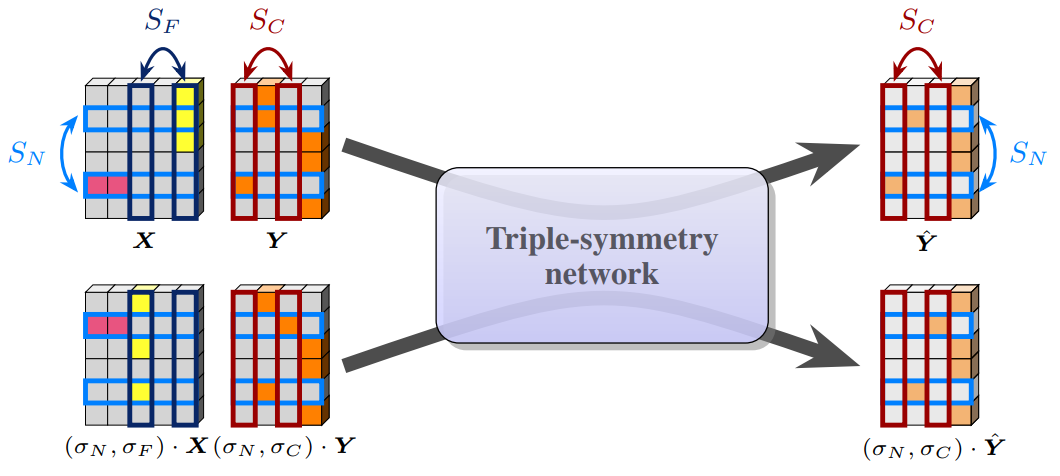



---
## Part 2: Single, Double, and Triple equivariant Linear Layers


### 2.1 DeepSets


The DeepSets layer implements all linear maps **T: $ℝ^{N \times F_{in}} → ℝ^{N \times F_{out}}$** that are **$S_N$–equivariant** (equivariant to node permutations).

**Mathematical Definition:**

$T(X) = \mathbf{1}_{N,N} X \Lambda_1 + X \Lambda_2.$



where:
- **X** ∈ $ℝ^{N×F_{in}}$ is the input node feature matrix
- **$\Lambda_1, \Lambda_2$** ∈ $ℝ^{F_{in}×F_{out}}$ are learnable weight matrices
- **$1_{N,N}$** is an all-ones matrix in $ℝ^{N×N}$

**Key Property:** Permuting the rows of $X$ (nodes) results in the same permutation of the output rows, preserving the node ordering while allowing information to flow through global aggregation.


**Remark.** Notice that in the characterization above, weight matrices only multiply $X$ on the **right**, never on the **left**. Intuitively, if we were to apply a learned weight matrix on the left (e.g., in the node dimension), the resulting map would implicitly fix a maximum graph size and break permutation symmetry: the operation would depend on the specific indexing of nodes rather than just their multiset structure. Consequently, a key design principle emerges: if we want a model to respect permutation symmetry along a given axis (nodes, features, or labels), we must avoid applying learned linear maps along that axis and instead restrict learnable transformations to the remaining dimensions.

In [ ]:
class DeepSetsLayer(nn.Module):
    """
    DeepSets layer: S_N-equivariant linear transformation.

    Implements T(X) = 1_{N,N} X Λ₁ + X Λ₂ where:
    - X ∈ ℝ^{N×F_in}
    - Λ₁, Λ₂ ∈ ℝ^{F_in×F_out}
    - Output: ℝ^{N×F_out}
    """
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super(DeepSetsLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        # Λ₁: weight for global aggregation term
        self.lambda1 = nn.Linear(in_features, out_features, bias=False)

        # Λ₂: weight for local term
        self.lambda2 = nn.Linear(in_features, out_features, bias=bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (N, F_in)
        Returns:
            Output tensor of shape (N, F_out)
        """
        N = x.shape[0]

        # Global aggregation: 1_{N,N} X Λ₁
        # Using mean for numerical stability (equivalent to sum up to scale)
        x_mean = x.mean(dim=0, keepdim=True)  # (1, F_in)
        x_mean_expanded = x_mean.repeat(N, 1)  # (N, F_in)
        global_term = self.lambda1(x_mean_expanded)  # (N, F_out)

        # Local term: X Λ₂
        local_term = self.lambda2(x)  # (N, F_out)

        # Combine: T(X) = 1_{N,N} X Λ₁ + X Λ₂
        out = global_term + local_term

        return out


### 2.2 DSSLayer (DeepSets for Symmetric elements)



We now introduce an additional symmetry across the feature dimension. In the standard DeepSets setting, only permutations of elements (nodes) are considered. Here, we require equivariance with respect to simultaneous permutations of both nodes and features. As a result, we can no longer apply an arbitrary learned weight matrix along the feature axis, since this would violate the desired feature-permutation symmetry.

Concretely, our input is initially a feature matrix $X \in \mathbb{R}^{N \times F}$. However, under the joint $S_N \times S_F$ symmetry, we are not allowed to apply unconstrained linear maps along either the node or feature axes. To regain expressive power while preserving symmetry, we lift the matrix $X$ into a third-order tensor  $\tilde{X} \in \mathbb{R}^{N \times F \times 1}$ by adding an extra channel axis. All learnable transformations are then implemented as linear maps acting only on this new axis.

In short, DSS layers operate by **lifting matrices to tensors** and **restricting learnable operations to the additional axis**, thereby respecting symmetry in both the node and feature dimensions.




The DSS layer implements all linear maps **T: $\mathbb{R}^{N \times F \times K_1}$ → $\mathbb{R}^{N \times F \times K_2}$** that are **($S_N \times S_F$)–equivariant** (equivariant to both node and feature permutations).

**Mathematical Definition.**

For each output channel $k_2 \in \{1,\dots,K_2\}$,

$$
T(X)_{:,:,k_2}
= \mathbf{1}_{N,N}\, X^{(1)}_{:,:,k_2}\, \mathbf{1}_{F,F}
+ \mathbf{1}_{N,N}\, X^{(2)}_{:,:,k_2}
+ X^{(3)}_{:,:,k_2}\, \mathbf{1}_{F,F}
+ X^{(4)}_{:,:,k_2},
$$

where, for $i = 1,\dots,4$,

$$
X^{(i)}_{:,:,k_2}
= \sum_{k_1=1}^{K_1} X_{:,:,k_1}\, \Lambda^{(i)}_{k_1,k_2},
$$

and each $\Lambda^{(i)} \in \mathbb{R}^{K_1 \times K_2}$ is a learnable weight matrix.


**Key Property:** Permuting nodes (first dimension) or features (second dimension) results in consistent permutations of the output.


In [ ]:
class DSSLayer(nn.Module):
    """
    DSS (DeepSets for Symmetric elements) layer: (S_N × S_F)-equivariant transformation.

    Implements the four-term decomposition for (S_N × S_F) equivariance.

    Input: X ∈ ℝ^{N×F×K1}
    Output: Y ∈ ℝ^{N×F×K2}
    """
    def __init__(self, in_channels: int, out_channels: int, bias: bool = False):
        super(DSSLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Four weight matrices Λ^{(1)}, Λ^{(2)}, Λ^{(3)}, Λ^{(4)}
        self.lambda1 = nn.Parameter(torch.randn(in_channels, out_channels))
        self.lambda2 = nn.Parameter(torch.randn(in_channels, out_channels))
        self.lambda3 = nn.Parameter(torch.randn(in_channels, out_channels))
        self.lambda4 = nn.Parameter(torch.randn(in_channels, out_channels))

        # Optional bias (per output channel)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)

        # Initialize weights
        nn.init.xavier_uniform_(self.lambda1)
        nn.init.xavier_uniform_(self.lambda2)
        nn.init.xavier_uniform_(self.lambda3)
        nn.init.xavier_uniform_(self.lambda4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input tensor of shape (N, F, K1)
        Returns:
            Output tensor of shape (N, F, K2)
        """
        # Compute X^{(i)} = X @ Λ^{(i)} for each i
        # x: (N, F, K1), lambda: (K1, K2) -> (N, F, K2)
        x1 = torch.einsum('nfk,kd->nfd', x, self.lambda1)
        x2 = torch.einsum('nfk,kd->nfd', x, self.lambda2)
        x3 = torch.einsum('nfk,kd->nfd', x, self.lambda3)
        x4 = torch.einsum('nfk,kd->nfd', x, self.lambda4)

        # Term 1: Global aggregation over both nodes and features
        # 1_{N,N} X^{(1)} 1_{F,F}
        term1 = x1.mean(dim=(0, 1), keepdim=True).expand_as(x1)

        # Term 2: Aggregation over nodes only
        # 1_{N,N} X^{(2)}
        term2 = x2.mean(dim=0, keepdim=True).expand_as(x2)

        # Term 3: Aggregation over features only
        # X^{(3)} 1_{F,F}
        term3 = x3.mean(dim=1, keepdim=True).expand_as(x3)

        # Term 4: Direct term (no aggregation)
        # X^{(4)}
        term4 = x4

        # Combine all terms
        out = term1 + term2 + term3 + term4

        # Add bias if specified
        if self.bias is not None:
            out = out + self.bias.unsqueeze(0).unsqueeze(0)

        return out


### 2.3 TripleSymmetryLayer (EquivLayer)


The TrippleSymmetryLayer implements linear maps  **T: $\mathbb{R}^{N \times (F + C) \times K_{\text{in}}} \rightarrow \mathbb{R}^{N \times (F + C) \times K_{\text{out}}}$**  
that are **$(S_N \times S_F \times S_C)$–equivariant** (equivariant to joint permutations of nodes, features, and labels).

**Mathematical Definition:**

For each node $v$, TrippleSymmetryLayer updates its feature embedding $X_v \in \mathbb{R}^{K_{\text{in}} \times F}$ and label embedding $Y_v \in \mathbb{R}^{K_{\text{in}} \times C}$ as:

$$
X'_v = \psi_X(
  W_1 X_v,\; \{ W_2 X_u \mid u \in \mathcal{N}(v) \},\;
  W_3 \nu(X),\; W_4 \nu(Y)
),
$$

$$
Y'_v = \psi_Y(
  W_5 Y_v,\; \{ W_6 Y_u \mid u \in \mathcal{N}(v) \},\;
  W_7 \nu(Y),\; W_8 \nu(X)
),
$$

where:
- $X \in \mathbb{R}^{N \times F \times K_{\text{in}}}$ and $Y \in \mathbb{R}^{N \times C \times K_{\text{in}}}$ are stacked node-wise embeddings,
- $W_i \in \mathbb{R}^{K_{\text{out}} \times K_{\text{in}}}$ are learnable weight matrices,
- $\mathcal{N}(v)$ is the neighbor set of node $v$,
- $\psi_X, \psi_Y$ are message-passing aggregation functions,
- $\nu$ aggregates along the feature/label axis.

**Key Property:**  
All learnable transformations act only on the channel dimension, while node, feature, and label axes are handled via permutation-equivariant message passing and permutation-invariant pooling. As a result, TrippleSymmetryLayers are $(S_N \times S_C \times S_F)$-equivariant, and can operate on graphs and label sets of arbitrary size.


In [ ]:
class EquivLayer(Module):
    def __init__(self, in_channel: int, out_channel: int, ls_num_layers: int):
        super(EquivLayer, self).__init__()
        self.out_channel = out_channel

        # x
        self.x_self = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
        self.x_aggr = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
        self.pool2x = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)

        self.x_bias = Parameter(torch.empty(out_channel))
        fan_in = get_fan_in(model=self.x_self)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        init.uniform_(self.x_bias, -bound, bound)

        # y
        self.y_self = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
        self.y_aggr = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
        self.pool2y = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)

        self.y_bias = Parameter(torch.empty(out_channel))
        fan_in = get_fan_in(model=self.y_self)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        init.uniform_(self.y_bias, -bound, bound)


    def single_forward(self, x: Tensor, y: Tensor, device, is_x: bool,
                       edge_index: Optional[Adj] = None) -> Tensor:
        # x Shape: [num_nodes, in_dim, in_channel]
        # y Shape: [num_nodes, num_classes, in_channel]
        x_str = 'x' if is_x else 'y'

        out_x = getattr(self, f'{x_str}_self')(x, edge_index=edge_index)
        out_x.add_(getattr(self, f'{x_str}_aggr')(x.mean(dim=1, keepdim=True), edge_index=edge_index))
        return out_x

    def forward(self, x: Tensor, y: Tensor,  device,
                edge_index: Optional[Adj] = None) -> Tuple[Tensor, Tensor]:
        out_x = self.single_forward(x=x, y=y, device=device, is_x=True,
                                    edge_index=edge_index)
        y = self.single_forward(x=y, y=x, device=device, is_x=False,
                                edge_index=edge_index)
        return out_x, y

### 2.4 Test permutation



Let's test our implementations to verify all architecture respects their corresponding symmetries.

We'll create test cases for each layer and verify that permuting inputs results in consistent permutations of outputs.


In [ ]:
# @title Helper functions

# Define helper functions

def get_fan_in(model: Module) -> float:
    # GraphConv has lin_rel and lin_root, use lin_rel for fan_in calculation
    return init._calculate_fan_in_and_fan_out(model.lin_rel.weight)[0]


def accuracy(preds: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Compute accuracy between predicted logits/probs and ground truth labels.

    Args:
        preds (torch.Tensor): shape [N, C] for logits or [N] for class indices
        targets (torch.Tensor): shape [N] with class indices

    Returns:
        float: accuracy in [0, 1]
    """
    if preds.dim() == 2:
        pred_labels = preds.argmax(dim=1)
    elif preds.dim() == 1:
        pred_labels = preds
    else:
        raise ValueError(f"Invalid shape for preds: {preds.shape}")

    correct = (pred_labels == targets).sum().item()
    total = targets.numel()

    return correct / total


def solve_ls_with_bias_cv(x: Tensor, y: Tensor, lambdas: List[float] = None, k_folds: int = 10) -> Tuple[Tensor, Tensor]:

    if lambdas is None:
        lambdas = [1e-15, 1e-8, 1e-6, 1e-4, 1e-2]  # log scale

    num_nodes, num_feat = x.shape
    num_labels = y.shape[1]

    # Add bias term
    x_with_bias = torch.cat([x, torch.ones(num_nodes, 1)], dim=1)

    best_lambda = None
    best_loss = float('inf')
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    for lam in lambdas:
        fold_losses = []
        for train_idx, val_idx in kf.split(x_with_bias):
            x_train, x_val = x_with_bias[train_idx], x_with_bias[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Augment system for ridge regularization
            x_aug = torch.cat([x_train, lam * torch.eye(num_feat + 1)], dim=0)
            y_aug = torch.cat([y_train, torch.zeros((num_feat + 1, num_labels))], dim=0)

            w = torch.linalg.lstsq(x_aug, y_aug, driver="gelss")[0]
            y_pred = x_val @ w
            fold_losses.append(torch.mean((y_pred - y_val) ** 2).item())

        avg_loss = sum(fold_losses) / len(fold_losses)
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_lambda = lam

    # Retrain on full data with best lambda
    x_aug_full = torch.cat([x_with_bias, best_lambda * torch.eye(num_feat + 1)], dim=0)
    y_aug_full = torch.cat([y, torch.zeros((num_feat + 1, num_labels))], dim=0)
    best_weights = torch.linalg.lstsq(x_aug_full, y_aug_full, driver="gelss")[0]
    return best_weights[:-1], best_weights[-1]


class LeastSquaresTransform(BaseTransform):
    def __init__(self, ls_num_layers: int, dataset_name: str, num_feat: int, seed: int):
        """
        Computes the least squares solution with L2 regularization
        between node features (data.x) and labels (data.y),
        using mean aggregation based on the graph structure.

        Args:
            ls_num_layers (int): Number of layers to apply mean aggregation before solving least squares.
        """
        super().__init__()
        self.ls_num_layers = ls_num_layers
        self.mean_aggr = SimpleConv(aggr='mean')
        self.cache_path = os.path.join(ROOT_DIR, 'datasets', dataset_name, f'{num_feat}feat', f'seed{seed}')

    def _save_cache(self, feature_label_mixing: Dict[str, Tensor], new_key_list: List[str]):
        if len(new_key_list) == 0:
            return
        os.makedirs(self.cache_path, exist_ok=True)

        # Save each key-value pair separately
        for key in new_key_list:
            with open(os.path.join(self.cache_path, f"{key}.pkl"), "wb") as f:
                pickle.dump(feature_label_mixing[key], f)

    def _load_cache(self) -> Dict[str, Tensor]:
        if not os.path.exists(self.cache_path):
            return {}

        # Load all ".pkl" file names in the self.cache_path folder (excluding "keys.pkl")
        key_files = os.listdir(self.cache_path)
        keys = {file[:-4] for file in key_files if file.endswith(".pkl")}

        # Load each transformation separately
        feature_label_mixing = {}
        for key in keys:
            key_path = os.path.join(self.cache_path, f"{key}.pkl")
            if os.path.exists(key_path):
                with open(key_path, "rb") as f:
                    feature_label_mixing[key] = pickle.load(f)

        return feature_label_mixing

    def __call__(self, data):
        feature_label_mixing = self._load_cache()
        xy_keys = list(feature_label_mixing.keys())

        # pool calc rescale
        pool_x = data.x.mean(dim=1, keepdim=True)
        pool_y = data.y_mat.mean(dim=1, keepdim=True)

        if 'pool2y_w' not in xy_keys:
            feature_label_mixing[f'pool2y_w'], feature_label_mixing[f'pool2y_b'] = \
                solve_ls_with_bias_cv(x=pool_x[data.train_mask], y=data.y_mat[data.train_mask])

        if 'pool2x_w' not in xy_keys:
            feature_label_mixing[f'pool2x_w'], feature_label_mixing[f'pool2x_b'] = \
                solve_ls_with_bias_cv(x=pool_y[data.train_mask], y=data.x[data.train_mask])

        if self.ls_num_layers >= 0:
            for is_hetero in [False, True]:
                x_l = copy.deepcopy(data.x)
                str_suffix = '_hetero' if is_hetero else ''
                for num_layer in range(self.ls_num_layers + 1):
                    if num_layer == 0 and is_hetero:
                        continue

                    x_l_train = x_l[data.train_mask]
                    y_train = data.y_mat[data.train_mask]
                    name = f'ls2y_{num_layer}{str_suffix}'
                    if name + '_w' not in xy_keys:
                        feature_label_mixing[name + '_w'], feature_label_mixing[name + '_b'] = \
                            solve_ls_with_bias_cv(x=x_l_train, y=y_train)

                    name = f'ls2x_{num_layer}{str_suffix}'
                    if name + '_w' not in xy_keys:
                        feature_label_mixing[name + '_w'], feature_label_mixing[name + '_b'] = \
                            solve_ls_with_bias_cv(x=y_train, y=x_l_train)

                    # Apply mean aggregation to features
                    if is_hetero:
                        x_l = (x_l - self.mean_aggr(x_l, edge_index=data.edge_index))
                    else:
                        x_l = self.mean_aggr(x_l, edge_index=data.edge_index)

        self._save_cache(feature_label_mixing, new_key_list=list(set(feature_label_mixing.keys()) - set(xy_keys)))
        setattr(data, 'feature_label_mixing', feature_label_mixing)
        return data



# GraphAny splits: https://github.com/DeepGraphLearning/GraphAny/blob/main/graphany/data.py#L59
def graphany_mask_splits(n_nodes, labels, num_train_nodes, seed=42):
    assert labels.ndim == 1, "y n_dim must equal 1"
    label_idx = np.arange(n_nodes)
    test_rate_in_labeled_nodes = (len(labels) - num_train_nodes) / len(labels)
    train_idx, test_and_valid_idx = train_test_split(
        label_idx,
        test_size=test_rate_in_labeled_nodes,
        random_state=seed,
        shuffle=True,
        stratify=labels,
    )
    valid_idx, test_idx = train_test_split(
        test_and_valid_idx,
        test_size=0.5,
        random_state=seed,
        shuffle=True,
        stratify=labels[test_and_valid_idx],
    )
    train_mask = torch.zeros(n_nodes, dtype=torch.bool)
    val_mask = torch.zeros(n_nodes, dtype=torch.bool)
    test_mask = torch.zeros(n_nodes, dtype=torch.bool)

    train_mask[train_idx] = True
    val_mask[valid_idx] = True
    test_mask[test_idx] = True

    return train_mask, val_mask, test_mask


def get_masks(data: Data, seed: int) -> Tuple[Tensor, Tensor, Tensor]:
    if hasattr(data, "train_mask") and hasattr(data, "val_mask") and hasattr(data, "test_mask"):
        train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
    else:
        n_nodes = data.x.shape[0]
        label = data.y
        num_class = label.max().item() + 1
        train_mask, val_mask, test_mask = graphany_mask_splits(
            n_nodes, label, num_train_nodes=20 * num_class, seed=seed
        )
    return train_mask, val_mask, test_mask


def split_data_per_fold(data: Data, seed: int, ls_num_layers: int, dataset_name: str) -> Data:
    train_mask, val_mask, test_mask = get_masks(data=data, seed=seed)
    # create a data split using the masks
    if train_mask.ndim == 2:
        # ! Multiple splits
        # Modified: Use the ${seed} split if not specified!
        split_index = seed
        # Avoid invalid split index
        split_index = (split_index % train_mask.ndim)
        train_mask = train_mask[:, split_index].squeeze()
        val_mask = val_mask[:, split_index].squeeze()
        if test_mask.ndim == 2:
            test_mask = test_mask[:, split_index].squeeze()
    dataset_copy = copy.deepcopy(data)
    setattr(dataset_copy, 'train_mask', train_mask)
    setattr(dataset_copy, 'val_mask', val_mask)
    setattr(dataset_copy, 'test_mask', test_mask)
    ls_pre_transform = LeastSquaresTransform(ls_num_layers=ls_num_layers, dataset_name=dataset_name,
                                             num_feat=data.x.shape[1], seed=seed)
    dataset_copy = ls_pre_transform(dataset_copy)
    return dataset_copy


@torch.no_grad()  # CPU function
def sample_k_nodes_per_label(label, visible_nodes, lp_ratio, num_class):
    train_size = visible_nodes.sum().item()
    k = math.floor(train_size * lp_ratio / num_class)
    node_idx_by_cls = [
        (label[visible_nodes] == lbl).nonzero().view(-1) for lbl in range(num_class)
    ]
    rnd_node_idx_by_cls = [
        label_indices[torch.randperm(len(label_indices))]
        for label_indices in node_idx_by_cls
    ]
    lp_indices = [
        label_indices[:k]
        for label_indices in rnd_node_idx_by_cls
    ]
    gt_indices = [
        label_indices[k:]
        for label_indices in rnd_node_idx_by_cls
    ]
    lp_mask = torch.zeros_like(visible_nodes, dtype=torch.bool).cpu()
    lp_mask[torch.cat(lp_indices)] = True
    gt_mask = torch.zeros_like(visible_nodes, dtype=torch.bool).cpu()
    gt_mask[torch.cat(gt_indices)] = True
    return lp_mask, gt_mask


def normalize(x):
    return x / (torch.norm(x, p=2, dim=1, keepdim=True) + EPS)


class RemoveSelfLoops(BaseTransform):
    def __call__(self, data: Data) -> Data:
        edge_index = data.edge_index
        mask = edge_index[0] != edge_index[1]  # Keep only edges where src != dst
        data.edge_index = edge_index[:, mask]
        return data


class NormalizeTransform(BaseTransform):
    def __init__(self):
        super().__init__()

    def __call__(self, data: Data) -> Data:
        data.x = normalize(x=data.x)
        return data


class DataSetFamily(Enum):
    homophilic = auto()
    actor = auto()

    @staticmethod
    def from_string(s: str):
        try:
            return DataSetFamily[s]
        except KeyError:
            raise ValueError()


class DataSet(Enum):
    """
    Dataset enum supporting only cora, pubmed, and actor
    """
    # homophilic
    cora = auto()
    pubmed = auto()
    actor = auto()

    @staticmethod
    def from_string(s: str):
        try:
            return DataSet[s]
        except KeyError:
            raise ValueError()

    def get_family(self) -> DataSetFamily:
        if self in [DataSet.cora, DataSet.pubmed]:
            return DataSetFamily.homophilic
        elif self is DataSet.actor:
            return DataSetFamily.actor
        else:
            raise ValueError(f'DataSet {self.name} not supported in dataloader')

    def load(self) -> Data:
        root = os.path.join(ROOT_DIR, 'datasets', self.name)
        os.makedirs(root, exist_ok=True)

        transform = T.Compose([
            T.ToUndirected(),
            RemoveSelfLoops(),
            T.RemoveDuplicatedEdges(),
            NormalizeTransform()
        ])

        dataset_family = self.get_family()
        if dataset_family is DataSetFamily.homophilic:
            data = Planetoid(root=root, name=self.name, transform=transform)[0]
        elif dataset_family is DataSetFamily.actor:
            data = Actor(root=root, transform=transform)[0]
        else:
            raise ValueError(f'DataSet {self.name} not supported')

        # Y preprocessing
        data.y = data.y.squeeze(dim=-1)
        y_mat = torch.nn.functional.one_hot(data.y).float()
        y_mat = normalize(x=y_mat)
        setattr(data, 'y_mat', y_mat)
        return data


In [ ]:
#@title Node, feature, and label permutation test

def test_node_permutation(model, inputs, forward_fn, output_key=None, atol=1e-5):
    """
    Test S_N equivariance (node permutation).

    Args:
        model: The model to test
        inputs: Dictionary of inputs (or single input tensor)
        forward_fn: Function that takes (model, inputs) and returns output(s)
        output_key: If forward_fn returns a tuple, which index to test (0 for x, 1 for y, etc.).
                    If None and output is tuple, tests all outputs.
        atol: Absolute tolerance for comparison

    Returns:
        tuple: (all_passed, max_diff) where all_passed is bool and max_diff is max difference if failed
    """
    # Get original output
    output_orig = forward_fn(model, inputs)

    # Handle tuple outputs
    if isinstance(output_orig, tuple):
        if output_key is not None:
            outputs_to_test = [(output_key, output_orig[output_key])]
        else:
            # Test all outputs in tuple
            outputs_to_test = [(i, out) for i, out in enumerate(output_orig)]
    else:
        outputs_to_test = [(None, output_orig)]

    all_passed = True
    max_diff = 0.0

    for key, output_orig_single in outputs_to_test:
        # Determine N (number of nodes) from output shape
        N = output_orig_single.shape[0]

        # Create node permutation
        perm_nodes = torch.randperm(N)

        # Permute inputs
        if isinstance(inputs, dict):
            inputs_perm = {}
            for k, v in inputs.items():
                if isinstance(v, torch.Tensor) and v.shape[0] == N:
                    inputs_perm[k] = v[perm_nodes]
                elif k == 'edge_index' and v is not None:
                    # Permute edge_index for graph models
                    inverse_perm = torch.zeros(N, dtype=torch.long, device=v.device)
                    inverse_perm[perm_nodes] = torch.arange(N, device=v.device)
                    inputs_perm[k] = inverse_perm[v]
                else:
                    inputs_perm[k] = v
        else:
            inputs_perm = inputs[perm_nodes]

        # Get permuted output
        output_perm_all = forward_fn(model, inputs_perm)
        if isinstance(output_perm_all, tuple):
            output_perm = output_perm_all[key] if key is not None else output_perm_all[0]
        else:
            output_perm = output_perm_all

        # Expected output (permuted original)
        output_expected = output_orig_single[perm_nodes]

        # Check if outputs match
        if not torch.allclose(output_perm, output_expected, atol=atol):
            all_passed = False
            max_diff = max(max_diff, (output_perm - output_expected).abs().max().item())

    return all_passed, max_diff if not all_passed else None



def test_feature_permutation(model, inputs, forward_fn, output_key=None, atol=1e-5):
    """
    Test S_F equivariance (feature permutation).

    Args:
        model: The model to test
        inputs: Dictionary of inputs (or single input tensor)
        forward_fn: Function that takes (model, inputs) and returns output(s)
        output_key: If forward_fn returns a dict, which key to test. If None, assumes single output.
        atol: Absolute tolerance for comparison

    Returns:
        bool: True if test passed, False otherwise
    """
    # Get original output
    if isinstance(inputs, dict):
        output_orig = forward_fn(model, inputs)
    else:
        output_orig = forward_fn(model, inputs)

    # Extract the output to test
    if output_key is not None:
        output_orig = output_orig[output_key]
    elif isinstance(output_orig, tuple):
        output_orig = output_orig[0]  # Test first output by default

    # Determine F (number of features) from output shape
    if output_orig.dim() < 2:
        return True, None  # No feature dimension to permute

    Feat = output_orig.shape[1]
    perm_features = torch.randperm(Feat)

    # Get F from input x if available
    F_input = Feat
    if isinstance(inputs, dict) and 'x' in inputs:
        x_input = inputs['x']
        if isinstance(x_input, torch.Tensor) and x_input.dim() >= 2:
            F_input = x_input.shape[1]  # Use input feature dimension

    # Permute inputs along feature dimension
    if isinstance(inputs, dict):
        inputs_perm = {}
        for k, v in inputs.items():
            if k == 'x' and isinstance(v, torch.Tensor) and v.dim() >= 2 and v.shape[1] == Feat:
                inputs_perm[k] = v[:, perm_features, ...]
            else:
                inputs_perm[k] = v
    else:
        if inputs.dim() >= 2 and inputs.shape[1] == Feat:
            inputs_perm = inputs[:, perm_features, ...]
        else:
            inputs_perm = inputs

    # Get permuted output
    output_perm = forward_fn(model, inputs_perm)
    if output_key is not None:
        output_perm = output_perm[output_key]
    elif isinstance(output_perm, tuple):
        output_perm = output_perm[0]

    # Expected output (permuted along feature dimension)
    output_expected = output_orig[:, perm_features, ...]

    # Check if outputs match
    if torch.allclose(output_perm, output_expected, atol=atol):
        return True, None
    else:
        max_diff = (output_perm - output_expected).abs().max().item()
        return False, max_diff


def test_label_permutation(model, inputs, forward_fn, output_key=None, atol=1e-5):
    """
    Test S_C equivariance (label permutation).

    Args:
        model: The model to test
        inputs: Dictionary of inputs
        forward_fn: Function that takes (model, inputs) and returns output(s)
        output_key: If forward_fn returns a dict, which key to test. If None, assumes tuple (x_out, y_out) and tests y_out.
        atol: Absolute tolerance for comparison

    Returns:
        bool: True if test passed, False otherwise
    """
    # Get original output
    if not isinstance(inputs, dict):
        return None, None  # Label permutation only applies to models with separate label inputs (not applicable)

    output_orig = forward_fn(model, inputs)

    # Extract the label output to test
    if output_key is not None:
        output_orig = output_orig[output_key]
    elif isinstance(output_orig, tuple):
        output_orig = output_orig[1]  # Test second output (y_out) by default
    else:
        return None, None  # No label output to test (not applicable)

    # Determine C (number of classes/labels) from output shape
    if output_orig.dim() < 2:
        return None, None  # Not applicable if output doesn't have label dimension

    C = output_orig.shape[1]
    perm_labels = torch.randperm(C)

    # Get C from input y if available
    C_input = C
    if isinstance(inputs, dict) and 'y' in inputs:
        y_input = inputs['y']
        if isinstance(y_input, torch.Tensor) and y_input.dim() >= 2:
            C_input = y_input.shape[1]  # Use input label dimension

    # Permute inputs along label dimension
    inputs_perm = {}
    for k, v in inputs.items():
        if k == 'y' and isinstance(v, torch.Tensor) and v.dim() >= 2 and v.shape[1] == C:
            inputs_perm[k] = v[:, perm_labels, ...]
        else:
            inputs_perm[k] = v

    # Get permuted output
    output_perm = forward_fn(model, inputs_perm)
    if output_key is not None:
        output_perm = output_perm[output_key]
    elif isinstance(output_perm, tuple):
        output_perm = output_perm[1]

    # Expected output (permuted along label dimension)
    output_expected = output_orig[:, perm_labels, ...]

    # Check if outputs match
    if torch.allclose(output_perm, output_expected, atol=atol):
        return True, None
    else:
        max_diff = (output_perm - output_expected).abs().max().item()
        return False, max_diff


def test_equivariant_layer(layer_class, layer_name, init_kwargs, input_creator, forward_fn,
                           expected_output_shape, test_symmetries=('S_N',), atol=1e-5, device=None):
    """
    Unified test function for equivariant layers.

    Args:
        layer_class: The layer class to test (e.g., DeepSetsLayer)
        layer_name: Name of the layer for printing
        init_kwargs: Dictionary of arguments to pass to layer_class.__init__
        input_creator: Function that returns (inputs_dict, device) where inputs_dict can be a dict or tensor
        forward_fn: Function that takes (model, inputs) and returns output(s)
        expected_output_shape: Expected output shape (tuple or dict of shapes)
        test_symmetries: Tuple of symmetries to test ('S_N', 'S_F', 'S_C')
        atol: Absolute tolerance for comparison
        device: Device to run tests on (None for CPU)

    Returns:
        None (prints test results)
    """
    if device is None:
        device = torch.device('cpu')

    print("=" * 60)
    print(f"Testing {layer_name}")
    print("=" * 60)

    # Create model
    model = layer_class(**init_kwargs).to(device)

    # Create inputs
    inputs, device_actual = input_creator(device)
    if device_actual is not None:
        device = device_actual

    # Move inputs to device if they're tensors
    if isinstance(inputs, dict):
        inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
    elif isinstance(inputs, torch.Tensor):
        inputs = inputs.to(device)

    # Forward pass
    output = forward_fn(model, inputs)

    # Test symmetries
    for symmetry in test_symmetries:
        if symmetry == 'S_N':
            print("\nTesting S_N equivariance (node permutation)...")
            passed, max_diff = test_node_permutation(model, inputs, forward_fn, atol=atol)
            if passed:
                print("✓ Node permutation equivariance test passed!")
            else:
                print("✗ Node permutation equivariance test failed!")
                print(f"Max difference: {max_diff:.2e}")

        elif symmetry == 'S_F':
            print("\nTesting S_F equivariance (feature permutation)...")
            passed, max_diff = test_feature_permutation(model, inputs, forward_fn, atol=atol)
            if passed:
                print("✓ Feature permutation equivariance test passed!")
            else:
                print("✗ Feature permutation equivariance test failed!")
                print(f"Max difference: {max_diff:.2e}")

        elif symmetry == 'S_C':
            print("\nTesting S_C equivariance (label permutation)...")
            passed, max_diff = test_label_permutation(model, inputs, forward_fn, atol=atol)
            if passed is None:
                print("⊘ Label permutation test not applicable (model has no separate label inputs)")
            elif passed:
                print("✓ Label permutation equivariance test passed!")
            else:
                print("✗ Label permutation equivariance test failed!")
                if max_diff is not None:
                    print(f"Max difference: {max_diff:.2e}")

    print("\n" + "=" * 60)


In [ ]:
# Test DeepSetsLayer using unified test function
def deepsets_input_creator(device):
    N, F_in = 5, 3
    X = torch.randn(N, F_in)
    return X, device

def deepsets_forward_fn(model, inputs):
    return model(inputs)

test_equivariant_layer(
    layer_class=DeepSetsLayer,
    layer_name="DeepSetsLayer",
    init_kwargs={'in_features': 3, 'out_features': 4},
    input_creator=deepsets_input_creator,
    forward_fn=deepsets_forward_fn,
    expected_output_shape=(5, 4),
    test_symmetries=('S_N', 'S_F'),  # DeepSetsLayer is only S_N-equivariant, not S_F-equivariant
    atol=1e-5
)


Testing DeepSetsLayer

Testing S_N equivariance (node permutation)...
✓ Node permutation equivariance test passed!

Testing S_F equivariance (feature permutation)...
✗ Feature permutation equivariance test failed!
Max difference: 1.44e+00



In [ ]:
# Test DSSLayer using unified test function
def dss_input_creator(device):
    N, F, K1 = 5, 3, 2
    X3 = torch.randn(N, F, K1)
    return X3, device

def dss_forward_fn(model, inputs):
    return model(inputs)

test_equivariant_layer(
    layer_class=DSSLayer,
    layer_name="DSSLayer",
    init_kwargs={'in_channels': 2, 'out_channels': 4},
    input_creator=dss_input_creator,
    forward_fn=dss_forward_fn,
    expected_output_shape=(5, 3, 4),
    test_symmetries=('S_N', 'S_F', 'S_C'),
    atol=1e-5
)


Testing DSSLayer

Testing S_N equivariance (node permutation)...
✓ Node permutation equivariance test passed!

Testing S_F equivariance (feature permutation)...
✓ Feature permutation equivariance test passed!

Testing S_C equivariance (label permutation)...
⊘ Label permutation test not applicable (model has no separate label inputs)



In [ ]:
# Test EquivLayer
def equivlayer_input_creator(device):
    N, F, C, K_in = 5, 3, 2, 1
    # Create a simple graph (fully connected for testing)
    edge_index = torch.combinations(torch.arange(N), 2).t().contiguous()
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)  # Make undirected

    x = torch.randn(N, F, K_in)  # Node features: (N, F, K_in)
    y = torch.randn(N, C, K_in)  # Node labels: (N, C, K_in)

    inputs = {
        'x': x,
        'y': y,
        'edge_index': edge_index,
        'device': device
    }
    return inputs, device

def equivlayer_forward_fn(model, inputs):
    return model(x=inputs['x'], y=inputs['y'],
                 device=inputs['device'], edge_index=inputs['edge_index'])

test_equivariant_layer(
    layer_class=EquivLayer,
    layer_name="EquivLayer (S_N × S_F × S_C)-equivariant layer",
    init_kwargs={'in_channel': 1, 'out_channel': 2, 'ls_num_layers': 0},
    input_creator=equivlayer_input_creator,
    forward_fn=equivlayer_forward_fn,
    expected_output_shape={'x': (5, 3, 2), 'y': (5, 2, 2)},
    test_symmetries=('S_N', 'S_F', 'S_C'),
    atol=1e-4
)

Testing EquivLayer (S_N × S_F × S_C)-equivariant layer

Testing S_N equivariance (node permutation)...
✓ Node permutation equivariance test passed!

Testing S_F equivariance (feature permutation)...
✓ Feature permutation equivariance test passed!

Testing S_C equivariance (label permutation)...
✓ Label permutation equivariance test passed!



---
## Part 3: Dataset and Preprocessing



Let's first load and explore a graph dataset to understand the structure.

### 3.1: Cora Citation Network

We'll use the **Cora** dataset, a citation network where:
- **Nodes** = Papers
- **Edges** = Citations  
- **Features** = Bag-of-words representation
- **Labels** = Paper topics (7 classes)





In [ ]:
# @title Load a small dataset (Cora citation network)
dataset = DataSet.cora
data = dataset.load()

print(f"Dataset: {dataset.name}")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of features per node: {data.x.shape[1]}")
print(f"Number of edges: {data.edge_index.shape[1]}")
print(f"Number of classes: {data.y.max().item() + 1}")
print(f"\nNode features shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Labels shape: {data.y.shape}")
print(f"\nHas train/val/test masks: {hasattr(data, 'train_mask')}")


Dataset: cora
Number of nodes: 2708
Number of features per node: 1433
Number of edges: 10556
Number of classes: 7

Node features shape: torch.Size([2708, 1433])
Edge index shape: torch.Size([2, 10556])
Labels shape: torch.Size([2708])

Has train/val/test masks: True


**Remark.** We now transition from set-based domains to graph domains. In the same spirit that graph neural networks emerge by replacing global set aggregations with local neighborhood aggregations, we extend TrippleSymmetryLayer to a graph setting. For instance, DeepSets becomes GIN by turning a global sum operator into a local, one-hop aggregation over neighbors. Analogously, TrippleSymmetryLayer becomes a TS-GNN by replacing its global aggregation operators with their graph-local counterparts, enabling equivariant feature–label updates conditioned on graph structure.


### 3.2: Key Data Structures

The model requires the following data structures:

- **x**: Node features with shape `[num_nodes, num_features]`
- **y_mat**: One-hot encoded labels (normalized) with shape `[num_nodes, num_classes]`
- **feature_label_mixing**: Dictionary containing pre-computed least squares transformations
- **edge_index**: Graph connectivity in COO format with shape `[2, num_edges]`

> **Note**: We'll explore `feature_label_mixing` in detail in the next section!




In [ ]:
# @title Prepare data with train/test split and least squares transformations [This is going to take 5mins]
seed = 42
ls_num_layers = 2  # Number of least squares layers

data = split_data_per_fold(
    data=data,
    seed=seed,
    ls_num_layers=ls_num_layers,
    dataset_name=dataset.name
)

print("✓ Data prepared with least squares transformations")
print(f"\nfeature_label_mixing keys: {list(data.feature_label_mixing.keys())[:5]}...")
print(f"Total conversion matrices: {len(data.feature_label_mixing)}")
print(f"\nExample conversion shape: {data.feature_label_mixing['pool2y_w'].shape}")


✓ Data prepared with least squares transformations

feature_label_mixing keys: ['ls2x_2_hetero_w', 'ls2y_2_hetero_w', 'ls2x_1_b', 'ls2y_2_b', 'pool2y_b']...
Total conversion matrices: 24

Example conversion shape: torch.Size([1, 7])



### 3.3: What are `feature_label_mixing`?

**Motivation.** In the basic TS-GNN architecture, feature–label interaction is implemented by **globally** summing/pooling over all features and all labels. While this captures full-context information, it also creates a severe bottleneck: every node sees the same mixed signal, and fine-grained structure is lost. To address this, we introduce a simpler and more expressive mixing mechanism based on least-squares solutions that directly couple feature and label embeddings.

A central design question for graph foundation models is **how strongly and in what form** feature and label embeddings should interact. Rich, well-structured information flow between these two spaces is crucial for building powerful GFMs, and our revised mixing terms are aimed precisely at improving this interaction without sacrificing symmetry or scalability.


The `feature_label_mixing` dictionary contains **pre-computed linear transformations** that map between feature and label spaces. These transformations are computed by solving least-squares optimization problems:


**Mathematical Formulation:**

$$
T_F \;=\; \arg\min_{T_F \in \mathbb{R}^{F \times C}} \,\|\, Y \;-\; A X T_F \,\|^2,
$$

$$
T_C \;=\; \arg\min_{T_C \in \mathbb{R}^{C \times F}} \,\|\, X \;-\; A Y T_C \,\|^2,
$$

where:
- $X \in \mathbb{R}^{N \times F}$ and $Y \in \mathbb{R}^{N \times C}$ are feature and label matrices,
- $A \in \mathbb{R}^{N \times N}$ is the (normalized) adjacency matrix,
- $T_F$ and $T_C$ are least-squares mixing transformations.

These projections transform features into the label space and labels into the feature space, respectively.





---
## Part 4: The Triple-Symmetry Graph Neural Network Architecture




A **Triple-Symmetry Graph Neural Network (TS-GNN)** is defined as  
$$
F \;=\; \pi \circ T^{(L)} \circ \sigma \circ T^{(L-1)} \circ \sigma \circ \cdots \circ T^{(1)},
$$
where each $T^{(\ell)}$ is an $(S_N \times S_F \times S_C)$-equivariant layer that acts jointly on node features and node labels, while also using the adjacency matrix. $\pi$ is the final readout that maps hidden embeddings to node-level predictions.

At layer $\ell$, each $T^{(\ell)}$ updates the feature representation $X^{(\ell)}_v \in \mathbb{R}^{K^{(\ell)} \times F}$ and label representation $Y^{(\ell)}_v \in \mathbb{R}^{K^{(\ell)} \times C}$ of node $v \in V$ through a combination of:


1. **Self-processing**: Processing the node's own features/labels

2. **Neighborhood aggregation**: Aggregating information from neighboring nodes

3. **Cross-space mixing**: Transforming between feature and label spaces using the pre-computed least squares transformationsThe architecture is ($S_N × S_F \times S_C$)-equivariant, as required for a graph foundation model.


This creates rich cross-interactions between features and labels while preserving the required symmetries.

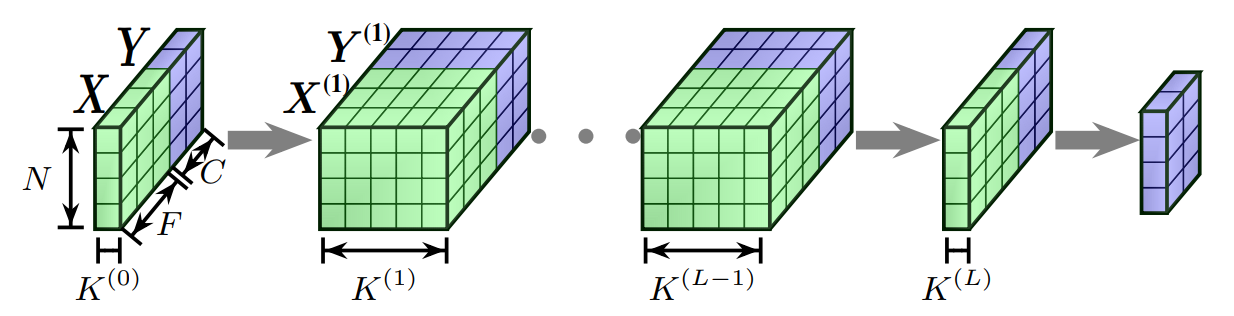

An illustration of the feature and label embeddings across the layers of our triple-symmetric graph neural
network architecture. The architecture is composed of feature-, label- and node-equivariant aggregation layers and a final feature-invariant projection layer.


### 4.1: Label Propagation Ratio (lp_ratio)




During training, only a **fraction** of training labels are used for propagation:

| Setting | Training | Testing |
|---------|----------|---------|
| **Label Propagation** | `lp_ratio × labels` (e.g., 50%) | **ALL labels** (100%) |
| **Loss Computation** | `(1 - lp_ratio) × labels` (e.g., 50%) | N/A |

**Why split labels?**
-  Prevents overfitting
-  Encourages generalization
-  Model learns to propagate information, not just memorize

> **Example**: With `lp_ratio=0.5`, 50% of labels are used for propagation, 50% for loss computation.

In [ ]:
# @title Definition of EquivLayer+`feature_label_mixing`
class EquivLayer(Module):
    def __init__(self, in_channel: int, out_channel: int, ls_num_layers: int):
        super(EquivLayer, self).__init__()
        self.out_channel = out_channel

        # x
        self.x_self = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
        self.x_aggr = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
        self.pool2x = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)

        self.x_bias = Parameter(torch.empty(out_channel))
        fan_in = get_fan_in(model=self.x_self)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        init.uniform_(self.x_bias, -bound, bound)

        # y
        self.y_self = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
        self.y_aggr = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
        self.pool2y = GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)

        self.y_bias = Parameter(torch.empty(out_channel))
        fan_in = get_fan_in(model=self.y_self)
        bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
        init.uniform_(self.y_bias, -bound, bound)

        # ls
        self.ls_num_layers = ls_num_layers
        if ls_num_layers >= 0:
            self.ls2y_layers = ModuleList([GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
                                           for _ in range(ls_num_layers + 1)])
            self.ls2x_layers = ModuleList([GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
                                           for _ in range(ls_num_layers + 1)])
            # hetero
            self.ls2y_hetero_layers = [GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
                                       for _ in range(1, ls_num_layers + 1)]
            self.ls2y_hetero_layers = ModuleList([Identity()] + self.ls2y_hetero_layers)
            self.ls2x_hetero_layers = [GraphConv(in_channels=in_channel, out_channels=out_channel, aggr='mean', node_dim=0, bias=False)
                                       for _ in range(1, ls_num_layers + 1)]
            self.ls2x_hetero_layers = ModuleList([Identity()] + self.ls2x_hetero_layers)

    def single_forward(self, x: Tensor, y: Tensor, feature_label_mixing: Dict[str, Tensor], device, is_x: bool,
                       edge_index: Optional[Adj] = None) -> Tensor:
        # x Shape: [num_nodes, in_dim, in_channel]
        # y Shape: [num_nodes, num_classes, in_channel]
        x_str = 'x' if is_x else 'y'

        out_x = getattr(self, f'{x_str}_self')(x, edge_index=edge_index)
        out_x.add_(getattr(self, f'{x_str}_aggr')(x.mean(dim=1, keepdim=True), edge_index=edge_index))
        w = feature_label_mixing[f'pool2{x_str}_w'].to(device=device)
        b = feature_label_mixing[f'pool2{x_str}_b'].to(device=device)
        out_x.add_(getattr(self, f'pool2{x_str}')(torch.einsum("ndk,dp->npk", y.mean(dim=1, keepdim=True), w)
                                                  + b.unsqueeze(dim=-1),
                                                  edge_index=edge_index))

        for num_layer in range(self.ls_num_layers + 1):
            w = feature_label_mixing[f'ls2{x_str}_{num_layer}_w'].to(device=device)
            b = feature_label_mixing[f'ls2{x_str}_{num_layer}_b'].to(device=device)
            out_x.add_(getattr(self, f'ls2{x_str}_layers')[num_layer](torch.einsum("ndk,dp->npk", y, w)
                                                                      + b.unsqueeze(dim=-1),
                                                                      edge_index=edge_index))
            if num_layer != 0:
                # y2x hetero
                w = feature_label_mixing[f'ls2{x_str}_{num_layer}_hetero_w'].to(device=device)
                b = feature_label_mixing[f'ls2{x_str}_{num_layer}_hetero_b'].to(device=device)
                out_x.add_(getattr(self, f'ls2{x_str}_hetero_layers')[num_layer](torch.einsum("ndk,dp->npk", y, w)
                                                                                 + b.unsqueeze(dim=-1),
                                                                                 edge_index=edge_index))
        return out_x

    def forward(self, x: Tensor, y: Tensor, feature_label_mixing: Dict[str, Tensor], device,
                edge_index: Optional[Adj] = None) -> Tuple[Tensor, Tensor]:
        out_x = self.single_forward(x=x, y=y, feature_label_mixing=feature_label_mixing, device=device, is_x=True,
                                    edge_index=edge_index)
        y = self.single_forward(x=y, y=x, feature_label_mixing=feature_label_mixing, device=device, is_x=False,
                                edge_index=edge_index)
        return out_x, y


### 4.2 Defining TS-GNN

In [ ]:
class GFMArgs(NamedTuple):
    hid_channel: int
    num_layers: int
    ls_num_layers: int
    lp_ratio: float



class GFM(Module):
    def __init__(self, gfm_args: GFMArgs):
        super(GFM, self).__init__()
        self.lp_ratio = gfm_args.lp_ratio

        # encoder
        dim_list = [1] + [gfm_args.hid_channel] * (gfm_args.num_layers - 1) + [1]
        self.equiv_layers = [EquivLayer(in_channel=in_channel, out_channel=out_channel,
                                        ls_num_layers=gfm_args.ls_num_layers)
                             for layer, (in_channel, out_channel) in enumerate(zip(dim_list[:-1], dim_list[1:]))]
        self.num_layers = gfm_args.num_layers
        self.equiv_layers = ModuleList(self.equiv_layers)


    def forward(
        self,
        x: Tensor,                    # input features: shape [num_edges, in_dim]
        train_y: Tensor,              # training labels (one-hot or soft): shape [num_nodes, num_classes]
        feature_label_mixing: Dict[str, Tensor],  # dict of least-squares weights and biases for least-squares transforms
        is_batch: bool,               # whether using batched training (sampling k nodes per class)
        device,                       # target device (cpu/cuda)
        edge_index: Optional[Adj]     # edge indices
    ) -> Tuple[Tensor, OptTensor]:     # returns: logits/embeddings [num_nodes, num_classes], gt_mask (or None)
        x = copy.deepcopy(x)
        train_y = copy.deepcopy(train_y)

        with torch.no_grad():
            # sampling prep
            train_mask = train_y.sum(dim=1).to(torch.bool)
            if is_batch:
                lp_mask, gt_mask =\
                    sample_k_nodes_per_label(label=train_y.argmax(dim=1), visible_nodes=train_mask,
                                             lp_ratio=self.lp_ratio, num_class=train_y.shape[1])
            else:
                lp_mask = train_mask
                gt_mask = None

        # x encoding
        x = x.unsqueeze(dim=-1).to(device=device)
        train_y[~lp_mask] = 0
        y = train_y.unsqueeze(dim=-1).to(device=device)
        if isinstance(edge_index, Tensor):
            edge_index = edge_index.to(device=device)
        feature_label_mixing = {key: value.to(device=device) if isinstance(value, Tensor) else value
                          for key, value in feature_label_mixing.items()}
        for idx, layer in enumerate(self.equiv_layers):
            x, y = layer(x=x, y=y, feature_label_mixing=feature_label_mixing, device=device,
                         edge_index=edge_index)

            if idx != self.num_layers - 1:
                x = F.gelu(x)
                y = F.gelu(y)
        return y.squeeze(dim=-1), gt_mask

### 4.3 Building TS-GNN model

Now let's build a simple TS-GNN model by initialize an instance:

In [ ]:

gfm_args = GFMArgs(
    hid_channel=8,              # Hidden dimension
    num_layers=2,                # Number of equivariant layers
    ls_num_layers=2,             # Number of least squares layers
    lp_ratio=0.5                 # Label propagation ratio (50% of labels used for propagation)
)

model = GFM(gfm_args=gfm_args)
print(f"✓ Model created with {gfm_args.num_layers} layers")
print(f"\nModel architecture:")
print(model)


✓ Model created with 2 layers

Model architecture:
GFM(
  (equiv_layers): ModuleList(
    (0): EquivLayer(
      (x_self): GraphConv(1, 8)
      (x_aggr): GraphConv(1, 8)
      (pool2x): GraphConv(1, 8)
      (y_self): GraphConv(1, 8)
      (y_aggr): GraphConv(1, 8)
      (pool2y): GraphConv(1, 8)
      (ls2y_layers): ModuleList(
        (0-2): 3 x GraphConv(1, 8)
      )
      (ls2x_layers): ModuleList(
        (0-2): 3 x GraphConv(1, 8)
      )
      (ls2y_hetero_layers): ModuleList(
        (0): Identity()
        (1-2): 2 x GraphConv(1, 8)
      )
      (ls2x_hetero_layers): ModuleList(
        (0): Identity()
        (1-2): 2 x GraphConv(1, 8)
      )
    )
    (1): EquivLayer(
      (x_self): GraphConv(8, 1)
      (x_aggr): GraphConv(8, 1)
      (pool2x): GraphConv(8, 1)
      (y_self): GraphConv(8, 1)
      (y_aggr): GraphConv(8, 1)
      (pool2y): GraphConv(8, 1)
      (ls2y_layers): ModuleList(
        (0-2): 3 x GraphConv(8, 1)
      )
      (ls2x_layers): ModuleList(
       

---
## Part 5: Training a TS-GNN Model





### 5.1 Training Setup



In the label inpainting task, we randomly mask the labels of a subset of nodes at each epoch and optimize the model to predict the masked labels from the node features and the remaining visible labels. This training procedure enables the model to learn generalizable patterns that work across different graphs and label sets.

During training, we use a **label propagation ratio** (`lp_ratio`) that controls how many labels are used for propagation versus loss computation. This prevents overfitting and helps the model generalize better.


In [ ]:
# Training setup
model = GFM(gfm_args=gfm_args).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
max_epochs = 100  # Reduced for tutorial
cross_entropy = torch.nn.CrossEntropyLoss()

# Prepare graph format
edge_index = data.edge_index.to(device)

# Training loop
train_losses = []
val_accs = []
test_accs = []

for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    train_y = data.y_mat.clone()
    train_y[~data.train_mask] = 0

    scores, gt_mask = model(
        x=data.x.to(device),
        train_y=train_y.to(device),
        feature_label_mixing=data.feature_label_mixing,
        is_batch=True,
        device=device,
        edge_index=edge_index
    )

    # Loss on ground truth nodes (not used for propagation)
    gt_mask = gt_mask.to(device)
    loss = cross_entropy(scores[gt_mask], data.y.to(device)[gt_mask])

    # Backward pass
    loss.backward()
    optimizer.step()

    # Evaluation
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            # Validation
            train_y = data.y_mat.clone()
            train_y[~data.train_mask] = 0
            scores, _ = model(
                x=data.x.to(device),
                train_y=train_y.to(device),
                feature_label_mixing=data.feature_label_mixing,
                is_batch=False,
                device=device,
                edge_index=edge_index
            )

            val_acc = accuracy(scores[data.val_mask.to(device)], data.y.to(device)[data.val_mask])
            test_acc = accuracy(scores[data.test_mask.to(device)], data.y.to(device)[data.test_mask])

            train_losses.append(loss.item())
            val_accs.append(val_acc)
            test_accs.append(test_acc)

            print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")


Epoch  10 | Loss: 0.4026 | Val Acc: 0.6820 | Test Acc: 0.6880
Epoch  20 | Loss: 0.0456 | Val Acc: 0.7220 | Test Acc: 0.7660
Epoch  30 | Loss: 0.0085 | Val Acc: 0.7380 | Test Acc: 0.7770
Epoch  40 | Loss: 0.0033 | Val Acc: 0.7400 | Test Acc: 0.7850
Epoch  50 | Loss: 0.0018 | Val Acc: 0.7380 | Test Acc: 0.7880
Epoch  60 | Loss: 0.0015 | Val Acc: 0.7400 | Test Acc: 0.7890
Epoch  70 | Loss: 0.0012 | Val Acc: 0.7400 | Test Acc: 0.7900
Epoch  80 | Loss: 0.0011 | Val Acc: 0.7400 | Test Acc: 0.7900
Epoch  90 | Loss: 0.0010 | Val Acc: 0.7400 | Test Acc: 0.7920
Epoch 100 | Loss: 0.0009 | Val Acc: 0.7420 | Test Acc: 0.7920


###  5.2 Visualizing Training Progress



Let's visualize how the model improves over time:

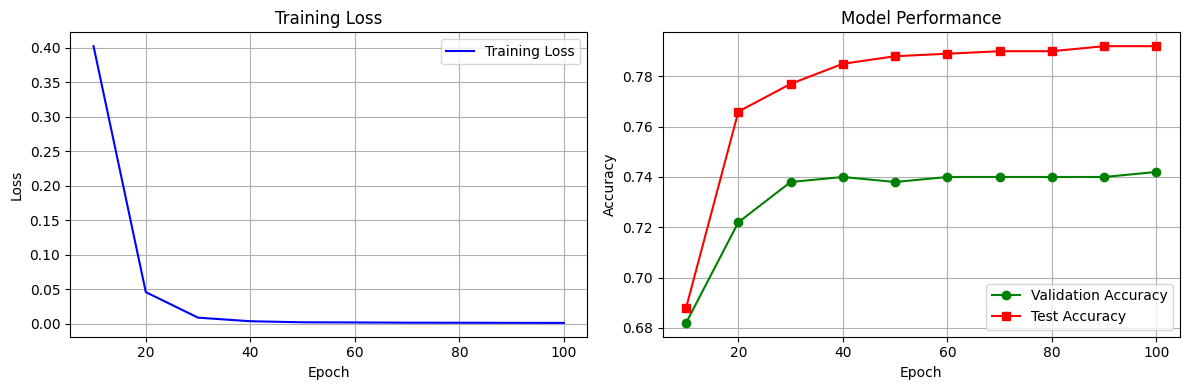


Final Test Accuracy: 0.7920


In [ ]:
# @title Plot training progress

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

epochs = [(i+1)*10 for i in range(len(train_losses))]

ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, val_accs, 'g-', label='Validation Accuracy', marker='o')
ax2.plot(epochs, test_accs, 'r-', label='Test Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Performance')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Test Accuracy: {test_accs[-1]:.4f}")


### 5.3 TS-GNN over unseen test graph











To assess generalization beyond the training graph, we evaluate the model on a set of held-out benchmark datasets. Each test graph is loaded independently and processed using the same data-splitting routine to ensure a consistent train/validation/test layout across datasets.

In [ ]:
# Test datasets:
test_datasets = [
    DataSet.pubmed,
    DataSet.actor,
]

In [ ]:

ts_gnn_results = {}
random_guess_results = {}

for test_dataset in test_datasets:
    # Load and split dataset
    test_data = test_dataset.load()
    test_data = split_data_per_fold(
        data=test_data,
        seed=42,
        ls_num_layers=gfm_args.ls_num_layers,
        dataset_name=test_dataset.name
    )

    # Move graph data to device
    x = test_data.x.to(device)
    edge_index = test_data.edge_index.to(device)

    # Prepare label matrix: use only training labels
    train_y = test_data.y_mat
    train_y[~test_data.train_mask] = 0
    train_y = train_y.to(device)

    with torch.no_grad():
        # Forward pass
        scores, _ = model(
            x=x,
            train_y=train_y,
            feature_label_mixing=test_data.feature_label_mixing,
            is_batch=False,
            device=device,
            edge_index=edge_index
        )

        # Compute accuracy on test nodes
        test_mask = test_data.test_mask.to(device)
        true_labels = test_data.y.to(device)[test_mask]
        pred_scores = scores[test_mask]

        ts_acc = accuracy(pred_scores, true_labels)

        # Store TS-GNN result
        ts_gnn_results[test_dataset.name] = ts_acc

        # Compute random guess baseline for comparison
        num_classes = test_data.y.max().item() + 1
        random_acc = 1.0 / num_classes

    print(f"{name:<20} {ts_acc:<15.4f} {rand_acc:<15.4f}")


# ---------------------------------------------------------
# Print results
# ---------------------------------------------------------


for dataset_name in test_datasets:
    name = dataset_name.name
    ts_acc = ts_gnn_results[name]
    rand_acc = random_guess_results[name]




=== Zero-Shot Evaluation: TS-GNN vs Random Guess ===

Dataset              TS-GNN Acc      Random Guess   
pubmed               0.7690          0.3333         
actor                0.2796          0.2000         


---
<div align="center">

# Thank you for completing the tutorial!

**For more details, see the paper:**  
[**Equivariance Everywhere All At Once: A Recipe for Graph Foundation Models**](https://arxiv.org/abs/2506.14291) (NeurIPS 25)

</div>

---

